In [1]:
%matplotlib inline
######################################################################################################
#
#         SCRIPT DESCRIPTION: Basic Q-Learning in a single intersection
#
#         Input: Map name, route file
#         Output: Tripinfo.xml
#
#####################################################################################################

# Set MAP and time
used_map = 'cross_straight_random'
demand = "random"
# Choice of program (rr = Round Robin, Q = Q-Learning, random)
program = 'Q'
test_name = 'reduced'
# Q parameters
alpha   = 0.7         # Memory
gamma   = 0.3         # Discount
epsilon = 0.01         # Experimentality


simulation_length = 3600*24*7*2
color_vehicles = False

tracking_length = simulation_length
queue_tracking = True
positional_tracking = False

# Select whether to use previous experience
reloadQm  = True
saveQm    = True

# Set Path for Sumo Home folder
sumo_home_dir = "C:\Program Files (x86)\DLR\Sumo"
    
# Create storage if needed
if positional_tracking == True:
    tracking_data = [[] for _ in range(tracking_length)]
if queue_tracking == True:
    combined_queue = []

# Import basic libraries
import os
import sys
import optparse
import subprocess
import random
import random
import pdb
import xmltodict
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
from __future__ import absolute_import
from __future__ import print_function

# Current working directory
working_dir = os.getcwd()

# Set environment variable SUMO_HOME
try:
    # Use this line only to manually define SUMO_HOME path
    os.environ["SUMO_HOME"] = sumo_home_dir
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
except ImportError:
    sys.exit(
        "Please declare environment variable 'SUMO_HOME' as the root directory of your sumo installation (it should contain folders 'bin', 'tools' and 'docs')")

# Import API libraries
from sumolib import checkBinary
import traci

In [21]:
%%javascript
IPython.notebook.kernel.execute('notebook_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [22]:
# Set important directories
networks_dir = "C:\\Users\\acabrejasegea\\OneDrive - The Alan Turing Institute\\Desktop\\ATI\\0_TMF\\MLforFlowOptimisation\\Networks"
scripts_dir = "C:\\Program Files (x86)\\DLR\\Sumo\\tools\\"
runners_dir = "C:\\Users\\CabrejasEgeaAlvaro\\Desktop\\ATI\\05_ML_Traffic_Lights\\MLforFlowOptimisation\\"

notebook = (os.path.splitext(notebook_name))[0]

In [8]:
# Creates a route file for the simulation
def generate_routefile(simulation_length):
    random.seed(17)  # make tests reproducible
    # demand per second from different directions
    if demand == 'fixed':
        pWE = 1. / 8
        pEW = 1. / 8
        pNS = 1. / 15
        pSN = 1. / 15
    elif demand == "random":
        thresholds = np.linspace(0,simulation_length,1+7*4*4)
        pWE_v  = np.linspace(0.04, 0.16, 5)
        pEW_v  = np.linspace(0.04, 0.16, 5)
        pNS_v = np.linspace(0.04, 0.16, 5)
        pSN_v = np.linspace(0.04, 0.16, 5)
    else:
        sys.exit("Error in kind of demand, please choose random or fixed")
    
    # Algorithmic access to routefile (names need to be consistent)
    with open(os.path.join(networks_dir, used_map, (used_map + '.rou.xml')), "w") as routes:
        print("""<routes>
        <vType id="typeWE" accel="0.8" decel="4.5" sigma="0.5" length="5" minGap="2" maxSpeed="25" guiShape="passenger"/>
        <vType id="typeNS" accel="0.8" decel="4.5" sigma="0.5" length="5" minGap="2" maxSpeed="25" guiShape="passenger"/>

        <route id="right" edges="iW oE" />
        <route id="left" edges="iE oW" />
        <route id="down" edges="iN oS" />
        <route id="up" edges="iS oN" />""", file=routes)
        lastVeh = 0
        vehNr = 0
        for i in range(simulation_length):
            if demand == "random":
                if i in thresholds:
                    pWE = random.choice(pWE_v)
                    pEW = random.choice(pEW_v)
                    pNS = random.choice(pNS_v)
                    pSN = random.choice(pSN_v)
                    
            if random.uniform(0, 1) < pWE:
                print('    <vehicle id="right_%i" type="typeWE" route="right" depart="%i" />' % (
                    vehNr, i), file=routes)
                vehNr += 1
                lastVeh = i
            if random.uniform(0, 1) < pEW:
                print('    <vehicle id="left_%i" type="typeWE" route="left" depart="%i" />' % (
                    vehNr, i), file=routes)
                vehNr += 1
                lastVeh = i
            if random.uniform(0, 1) < pNS:
                print('    <vehicle id="down_%i" type="typeNS" route="down" depart="%i" />' % (
                    vehNr, i), file=routes)
                vehNr += 1
                lastVeh = i
            if random.uniform(0, 1) < pSN:
                print('    <vehicle id="down_%i" type="typeNS" route="up" depart="%i" />' % (
                    vehNr, i), file=routes)
                vehNr += 1
                lastVeh = i
        print("</routes>", file=routes)

In [9]:
class NetworkParser:

    def __init__(self, file_path):
        self.junctions = dict()
        self.junction_lights = dict()

        with open(file_path) as f:
            self.file = xmltodict.parse(f.read())

    def get_lane_ids(self):
        for junction in self.file['net']['junction']:
            if junction['@type'] == 'traffic_light':
                self.junctions[junction['@id']] = junction['@incLanes'].split(' ')
        return self.junctions

    # Given a LaneID it returns the traffic light ID
    def get_trafficlights_by_laneID(self, laneID):
        for connection in self.file['net']['connection']:
            if connection['@from'] == laneID.split('_')[0] and '@tl' in connection:
                return connection['@tl']

    def get_junction_trafficlights(self):
        # If the dictionarty for junctions is empty
        if not self.junctions:
            self.get_lane_ids()
        for junctionID in self.junctions.keys():
            for lane in self.junctions[junctionID]:
                traffic_light = self.get_trafficlights_by_laneID(lane)
                if traffic_light in self.junction_lights and lane not in self.junction_lights[traffic_light]:
                    self.junction_lights[traffic_light].append(lane)
                else:
                    self.junction_lights[traffic_light] = []
        return self.junction_lights

    def get_traffic_light(self, laneID):
        if not self.junction_lights:
            self.get_junction_trafficlights()
        for traffic_light, lanes in self.junction_lights.iteritems():
            if laneID in lanes:
                return traffic_light

    def get_phases(self, traffic_light):
        phases = []
        z = 0
        for tls in self.file['net']['tlLogic']:
            if z < 1:
                a=0
            z+=1
            if tls['@id'] == traffic_light:
                for tls_phase in tls['phase']:
                    phases.append(tls_phase)
        return phases

In [10]:
class Qlearner:
    def __init__(self,TLid,lanes,phases):
        self.jid     = TLid
        self.TLid    = TLid
        self.laneids = lanes
        self.Nlanes  = len(self.laneids)                                #len(nodes.junctions[self.jid])
        self.phases  = range(0, 23)                            #traci.trafficlights.getallPhases
        num_phases   = len(self.phases)
        self.Qm      = np.zeros((9, 6))
        
        self.state   = 0
        self.action  = 0
                                
        self.cycle_time = 90
        
        self.historic_reward = list()
        self.historic_queues = [[] for x in range(self.Nlanes)]
  
    def set_action(self,action):                               
        traci.trafficlights.setProgram(self.jid, str(action))
                                                                

    def get_reward(self):
        # Reward defined as a measure of the amount of waiting in the intersection
        return -sum([traci.lane.getLastStepHaltingNumber(lane_id) for lane_id in self.laneids])
 

    def get_state(self,threshold_l=3):
        # State is defined as a combination b/w 5 load level for the 2 routes
        NS_occupancy = traci.lane.getLastStepHaltingNumber("iN_0") + traci.lane.getLastStepHaltingNumber("iS_0")
        EW_occupancy = traci.lane.getLastStepHaltingNumber("iE_0") + traci.lane.getLastStepHaltingNumber("iW_0")

        NS_state = np.trunc(NS_occupancy/8)
        EW_state = np.trunc(EW_occupancy/8)
        
        if NS_state > 2:
            NS_state = 2
        if EW_state >2:
            EW_state = 2
        
        state = int(NS_state + 3* EW_state)

        return(state)

    def update(self,gamma=gamma,alpha=alpha,epsilon=epsilon):
        
        # Get current state, action from class
        state    = self.state
        action   = self.action
        # Generate new action and the reward
        newstate = self.get_state()
        reward   = self.get_reward()
        self.historic_reward.append(reward)
        
        if program == 'Q':
            # Update the Q matrix
            self.Qm[state, action] = self.Qm[state, action]*(1-alpha) + alpha*(reward + gamma*np.max(self.Qm[newstate,:]))

        # Choice of program (Explore or exploit)
        if program == 'Q':
            r=np.random.rand(1)
            if r > epsilon :
                newaction = np.argmax(self.Qm[state,:])
            else:
                newaction = np.random.randint(0, 5)
        elif program == 'rr':
            newaction = 99
        elif program == 'random':
            newaction = np.random.randint(0,5)
        
        # Set variables for next loop and reset cycle timer
        self.state = newstate
        self.action = newaction
                                
        self.set_action(newaction)

In [11]:
def run(learners = []):
    cycle_timer = 0
    timer = 0
    while traci.simulation.getMinExpectedNumber() > 0:
        traci.simulationStep()
        timer = timer + 1
        if cycle_timer == 90:
            for learner in learners:
                learner.update()
            cycle_timer = 0
        else:
            cycle_timer = cycle_timer + 1    
        if queue_tracking == True:
            combined_queue.append(traci.lane.getLastStepHaltingNumber(learners[0].laneids[0])+
                                     traci.lane.getLastStepHaltingNumber(learners[0].laneids[1])+
                                     traci.lane.getLastStepHaltingNumber(learners[0].laneids[2])+
                                     traci.lane.getLastStepHaltingNumber(learners[0].laneids[3]))
            for k in range(4):
                learners[0].historic_queues[k].append(traci.lane.getLastStepHaltingNumber(learners[0].laneids[k]))
            
        if positional_tracking == True:
            vehicles = traci.vehicle.getIDList()
            for vehicle in vehicles:
                tracking_data[timer].append(tuple((vehicle, 
                                                    traci.vehicle.getPosition(vehicle),
                                                    traci.vehicle.getCO2Emission(vehicle),
                                                    traci.vehicle.getNOxEmission(vehicle))))
        
        if color_vehicles == True:
            vehicleIDs = traci.vehicle.getIDList()
            waiting_time = list()
            for vehicle in vehicleIDs:
                wait = traci.vehicle.getWaitingTime(vehicle)
                if wait >= 20:
                    traci.vehicle.setColor(vehicle,(255,0,0,255))
                elif wait >= 1:
                    traci.vehicle.setColor(vehicle,(255,255,0,255))
                if persistent_color == False:
                    if wait < 1:
                        traci.vehicle.setColor(vehicle,(0,255,0,255))

    
    sys.stdout.flush()

### ORIGINAL SIMPLE CONTROLLER BELOW ###
# The program looks like this
#    <tlLogic id="0" type="static" programID="0" offset="0">
# the locations of the tls are      NESW
#        <phase duration="31" state="GrGr"/>
#        <phase duration="6"  state="yryr"/>
#        <phase duration="31" state="rGrG"/>
#        <phase duration="6"  state="ryry"/>
#    </tlLogic>
#
#def run():
#    """execute the TraCI control loop"""
#    step = 0
#    # we start with phase 2 where EW has green
#    traci.trafficlight.setPhase("0", 2)
#    while traci.simulation.getMinExpectedNumber() > 0:
#        traci.simulationStep()
#        if traci.trafficlight.getPhase("0") == 2:
#            # we are not already switching
#            if traci.inductionloop.getLastStepVehicleNumber("0") > 0:
#                # there is a vehicle from the north, switch
#                traci.trafficlight.setPhase("0", 3)
#            else:
#                # otherwise try to keep green for EW
#                traci.trafficlight.setPhase("0", 2)
#        step += 1
#    traci.close()
#    sys.stdout.flush()

In [12]:
def get_options():
    optParser = optparse.OptionParser()
    optParser.add_option("--nogui", action="store_true",
                         default=False, help="run the commandline version of sumo")
    options, args = optParser.parse_args()
    return options

In [13]:
# Deployment of Network Parser (input is network file)
npa = NetworkParser(os.path.join(networks_dir, used_map, (used_map + '.net.xml')))

In [14]:
nodes = npa.junctions
phase_list = [len(npa.get_phases(k)) for k in npa.get_junction_trafficlights().keys()]

In [15]:
# Checks
print(nodes)
print(nodes.keys())
print(phase_list)

{'gneJ1': ['iN_0', 'iE_0', 'iS_0', 'iW_0']}
dict_keys(['gneJ1'])
[28]


In [13]:
generate_routefile(simulation_length)

In [19]:
sumoBinary = checkBinary('sumo-gui')
# OR
# sumoBinary = checkBinary('sumo')

In [16]:
learners=[Qlearner(ID,lan,p) for ID, lan, p in zip(nodes.keys(),nodes.values(),phase_list)]

In [17]:
# Define Storage Files Containes
Qm_files = []
Reward_files = []
Queues_files = [[] for x in range(len(learners))]

# Define Storage Files Names
for i in range(len(learners)):
    Qm_files.append(networks_dir+"\\"+used_map+"\\"+"Qm_learner" + str(i) + '_' + demand + '_' + program + test_name +".npy")
    Reward_files.append(networks_dir+"\\"+used_map+"\\"+"Reward_learner" + str(i) + '_' + demand + '_' + program + test_name + ".pickle")
    for j in range(learners[i].Nlanes):
        Queues_files[i].append(networks_dir+"\\"+used_map+"\\"+"Queue_learner" + str(i) + '_lane' + str(j) + '_' + demand + '_' + program + test_name + ".pickle")

# Load Data from Storage Files
if reloadQm == True:
    for i in range(len(learners)):
        #Load Q-Matrix
        learners[i].Qm = np.load(Qm_files[i])
        print("Loaded pre-trained Q-matrix from file: "+ '\n' + Qm_files[i])
        
        #Load Historic Reward    
        with open(Reward_files[i], 'rb') as fp:
            learners[i].historic_reward = pickle.load(fp)
        print("Loaded Reward history from file: "+'\n' + Reward_files[i])
        
        #Load Historic Queues
        for j in range(learners[i].Nlanes):
            with open(Queues_files[i][j], 'rb') as fp:
                learners[i].historic_queues[j] = pickle.load(fp)
            print("Loaded Reward Queue from file: "+'\n'+ Queues_files[i][j])

Loaded pre-trained Q-matrix from file: 
C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Networks\cross_straight_random\Qm_learner0_random_Qreduced.npy
Loaded Reward history from file: 
C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Networks\cross_straight_random\Reward_learner0_random_Qreduced.pickle
Loaded Reward Queue from file: 
C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Networks\cross_straight_random\Queue_learner0_lane0_random_Qreduced.pickle
Loaded Reward Queue from file: 
C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Networks\cross_straight_random\Queue_learner0_lane1_random_Qreduced.pickle
Loaded Reward Queue from file: 
C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Networks\cross_straight_random\Queue_learner0_l

In [23]:
traci.start([sumoBinary, "-c", os.path.join(networks_dir, used_map, (used_map + '.sumocfg')),
                             "--tripinfo-output", os.path.join((notebook + '_out'), 'tripinfo.xml')])
run(learners)

FatalTraCIError: connection closed by SUMO

In [113]:
if saveQm == True:
    for i in range(len(learners)):
        # Save Qm
        np.save(Qm_files[i], learners[i].Qm)
        print("Saved Q-matrix to file: "+'\n'+Qm_files[i])
        
        # Save Historic Reward
        with open(Reward_files[i], 'wb') as fp:
            pickle.dump(learners[i].historic_reward, fp)
        print("Saved Reward history to file: "+'\n' +Reward_files[i])
        
        # Save Historic Queues
        for j in range(learners[i].Nlanes):
            with open(Queues_files[i][j], 'wb') as fp:
                pickle.dump(learners[i].historic_queues[j], fp)
            print("Saved Queue history to file: "+'\n' + Queues_files[i][j])

Saved Q-matrix to file: 
C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Networks\cross_straight_random\Qm_learner0_random_randomreduced.npy
Saved Reward history to file: 
C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Networks\cross_straight_random\Reward_learner0_random_randomreduced.pickle
Saved Queue history to file: 
C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Networks\cross_straight_random\Queue_learner0_lane0_random_randomreduced.pickle
Saved Queue history to file: 
C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Networks\cross_straight_random\Queue_learner0_lane1_random_randomreduced.pickle
Saved Queue history to file: 
C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Networks\cross_straight_random\Queue_learner0_lane2

In [95]:
learners[0].Qm

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

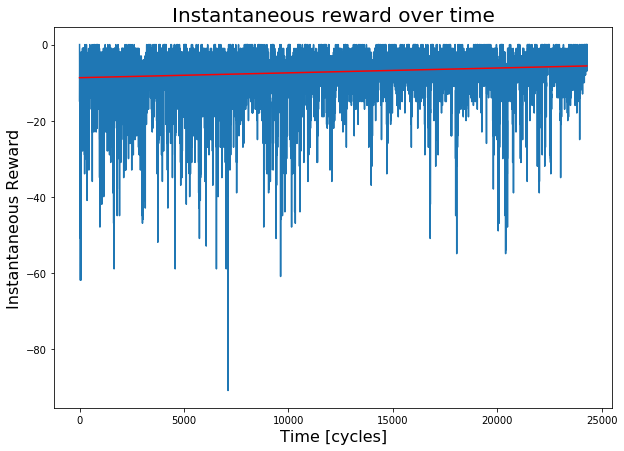

In [163]:
# Unsmoothed Reward vs Time with Linear Fit
plt.figure(figsize=(10,7))

fit_coef = np.polyfit(range(len(learners[0].historic_reward)),learners[0].historic_reward,1)
fit_line = np.polyval(fit_coef,range(len(learners[0].historic_reward)))

plt.plot(learners[0].historic_reward)
plt.plot(range(len(learners[0].historic_reward)), fit_line, 'r-')

plt.title("Instantaneous reward over time", fontsize = 20)
plt.xlabel("Time [cycles]"       , fontsize=16)
plt.ylabel("Instantaneous Reward", fontsize=16)

plt.show()

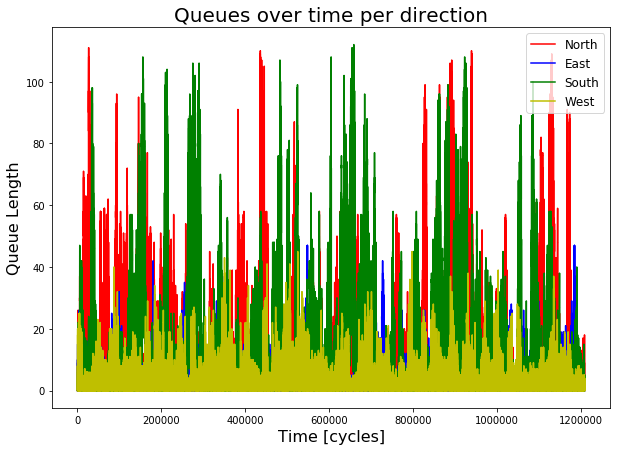

In [115]:
# Unsmoothed queues over time
plt.figure(figsize=(10,7))
styles = ['r-','b-','g-', 'y-']

time = range(len(learners[0].historic_queues[0]))

l1 = plt.plot(time, learners[0].historic_queues[0], styles[0])
l2 = plt.plot(time, learners[0].historic_queues[1], styles[1])
l3 = plt.plot(time, learners[0].historic_queues[2], styles[2])
l4 = plt.plot(time, learners[0].historic_queues[3], styles[3])

plt.title("Queues over time per direction", fontsize = 20)
plt.xlabel("Time [cycles]"       , fontsize=16)
plt.ylabel("Queue Length", fontsize=16)
plt.legend((l1[0],l2[0],l3[0],l4[0]),('North', 'East', 'South', 'West'),
           loc=1, fontsize = "large")

plt.show()

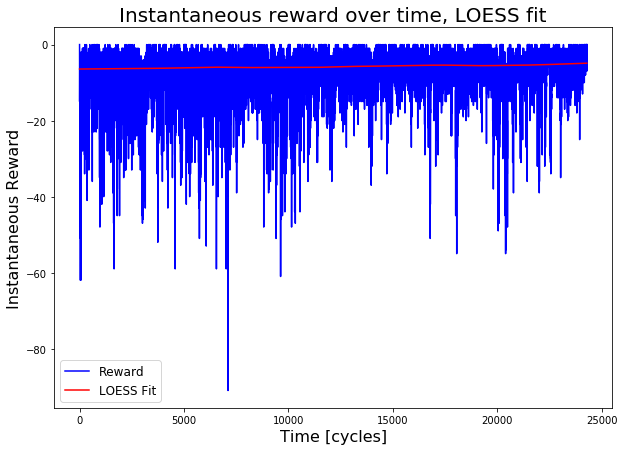

In [164]:
# LOWESS Smoothed Reward vs Time
plt.figure(figsize=(10,7))
styles = ['r-','b-']

time = range(len(learners[0].historic_reward))

d1 = sm.nonparametric.lowess(
    learners[0].historic_reward, range(len(learners[0].historic_reward)),
    frac= 0.3, it = 5, delta = 0 , is_sorted = True, missing = 'none', return_sorted = False)

l2 = plt.plot(time, learners[0].historic_reward, styles[1])
l1 = plt.plot(time, d1, styles[0])

plt.title("Instantaneous reward over time, LOESS fit", fontsize = 20)
plt.xlabel("Time [cycles]"       , fontsize=16)
plt.ylabel("Instantaneous Reward", fontsize=16)

plt.legend((l2[0],l1[0]),('Reward', 'LOESS Fit'),
           loc=3, fontsize = "large")

plt.show()


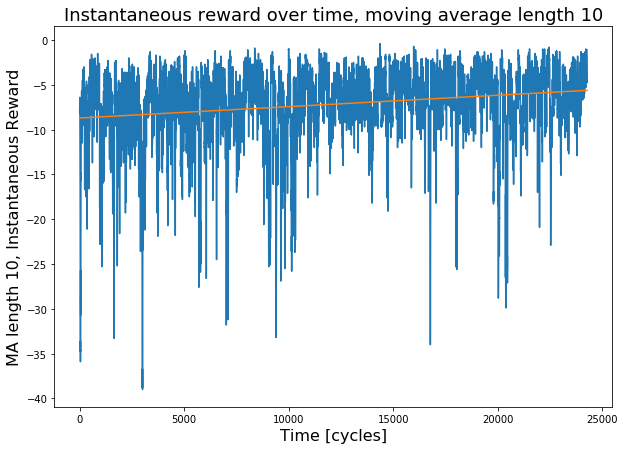

In [165]:
# MA-Smooother Reward vs Time with Linear Fit
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

m_average_length = 10
m_aver = moving_average(learners[0].historic_reward,m_average_length)
fitcoef = np.polyfit(range(len(m_aver)),m_aver,1)
fitline = np.polyval(fitcoef,range(len(m_aver)))

plt.figure(figsize=(10,7))
plt.plot(range(len(m_aver)),m_aver)
plt.plot(range(len(m_aver)),fitline)

plt.title(("Instantaneous reward over time, moving average length "+ str(m_average_length)), fontsize = 18)
plt.xlabel("Time [cycles]"       , fontsize=16)
plt.ylabel(("MA length "+str(m_average_length)+", Instantaneous Reward"), fontsize=16)

plt.show()

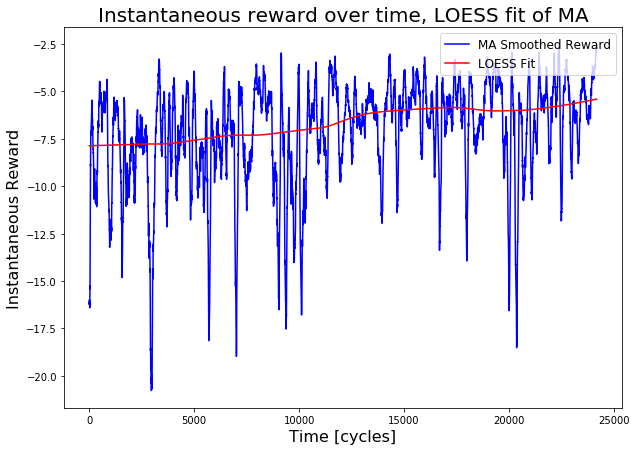

In [166]:
# LOWESS of MA Smoothed Reward vs Time
plt.figure(figsize=(10,7))
styles = ['r-','b-']

m_average_length = 100
m_aver = moving_average(learners[0].historic_reward,m_average_length)

time = range(len(m_aver))


d1 = sm.nonparametric.lowess(
    m_aver, range(len(m_aver)),
    frac= 0.3, it = 3, delta = 0 , is_sorted = True, missing = 'none', return_sorted = False)

l2 = plt.plot(time, m_aver, styles[1])
l1 = plt.plot(time, d1, styles[0])

plt.title("Instantaneous reward over time, LOESS fit of MA", fontsize = 20)
plt.xlabel("Time [cycles]"       , fontsize=16)
plt.ylabel("Instantaneous Reward", fontsize=16)

plt.legend((l2[0],l1[0]),('MA Smoothed Reward', 'LOESS Fit'),
           loc=1, fontsize = "large")

plt.show()


In [ ]:
#Preparation of plots Q vs RR vs Random
if program == 'Q':
    length_q = len(learners[0].historic_queues[0])
    hist_reward_q = learners[0].historic_reward
    m_aver_q = m_aver
    fitline_q = fitline
elif program == 'rr':
    length_rr = len(learners[0].historic_queues[0])
    hist_reward_rr = learners[0].historic_reward
    m_aver_rr = m_aver
    fitline_rr = fitline
elif program == 'random':
    length_r = len(learners[0].historic_queues[0])
    hist_reward_r = learners[0].historic_reward
    m_aver_r = m_aver
    fitline_r = fitline

In [167]:
# Plot MA-Smoothed Reward for all methods
plt.figure(figsize=(10,7))
l1=plt.plot(range(len(m_aver)),m_aver_q)
l2=plt.plot(range(len(m_aver)),m_aver_rr)
l3=plt.plot(range(len(m_aver)),m_aver_r)

plt.title(("Instantaneous reward, moving average length "+ str(m_average_length)), fontsize = 18)
plt.xlabel("Time [cycles]"       , fontsize=16)
plt.ylabel(("MA length "+str(m_average_length)+", Instantaneous Reward"), fontsize=16)
plt.legend((l1[0],l2[0],l3[0],l4[0]),('Q-Learning', 'Round Robin', 'Random'),
           loc=1, fontsize = "large")


NameError: name 'm_aver_q' is not defined

<Figure size 720x504 with 0 Axes>

In [ ]:
# Plot Linear fit on MA-Smoothed Reward for all methods
plt.figure(figsize=(10,7))
l1=plt.plot(range(len(m_aver)),fitline_q)
l2=plt.plot(range(len(m_aver)),fitline_rr)
l3=plt.plot(range(len(m_aver)),fitline_r)

plt.title(("Instantaneous reward, moving average length "+ str(m_average_length) + ". Linear Fit"), fontsize = 18)
plt.xlabel("Time [cycles]"       , fontsize=16)
plt.ylabel(("MA length "+str(m_average_length)+", Instantaneous Reward"), fontsize=16)
plt.legend((l1[0],l2[0],l3[0],l4[0]),('Q-Learning', 'Round Robin', 'Random'),
           loc=1, fontsize = "large")

In [ ]:
plt.figure(figsize=(40,28))


yn = np.polyval(a,range(len(learners[0].historic_reward)))

plt.plot(range(len(learners[0].historic_reward)),learners[0].historic_reward,1, 'b-')
plt.plot(range(len(learners[0].historic_reward)), yn, 'r-')

In [ ]:
plt.figure(figsize=(40,28))



Loaded Reward history from file: 
C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Networks\cross_straight_random\Reward_learner0_random_qreduced.pickle
Loaded Reward history from file: 
C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Networks\cross_straight_random\Reward_learner0_random_rrreduced.pickle
Loaded Reward history from file: 
C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Networks\cross_straight_random\Reward_learner0_random_randomreduced.pickle


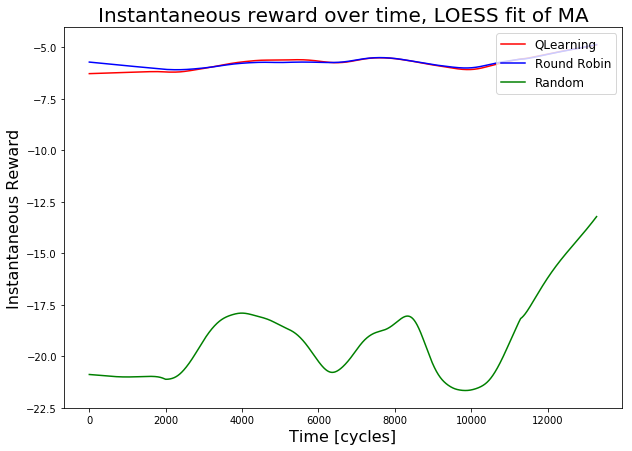

In [168]:
# Plot for LOESS fit lines in 3 methods
ma_length = 10

styles = ['r-','b-', 'g-']

def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

file_q      = networks_dir+"\\"+used_map+"\\"+"Reward_learner" + str(0) + '_' + demand + '_' + 'q' + test_name + ".pickle"
file_rr     = networks_dir+"\\"+used_map+"\\"+"Reward_learner" + str(0) + '_' + demand + '_' + 'rr' + test_name + ".pickle"
file_random = networks_dir+"\\"+used_map+"\\"+"Reward_learner" + str(0) + '_' + demand + '_' + 'random' + test_name + ".pickle"

#Load Historic Reward    
with open(file_q, 'rb') as fp:
    historic_q = pickle.load(fp)
print("Loaded Reward history from file: "+'\n' + file_q)
with open(file_rr, 'rb') as fp:
    historic_rr = pickle.load(fp)
print("Loaded Reward history from file: "+'\n' + file_rr)
with open(file_random, 'rb') as fp:
    historic_random = pickle.load(fp)
print("Loaded Reward history from file: "+'\n' + file_random)

historic_q_mod = historic_q[len(historic_q)-len(historic_rr):len(historic_q)]

ma_q      = moving_average(historic_q_mod, ma_length)
ma_rr     = moving_average(historic_rr, ma_length)
ma_random = moving_average(historic_random, ma_length)

d_q = sm.nonparametric.lowess(
    ma_q, range(len(ma_q)),
    frac= 0.3, it = 3, delta = 0 , is_sorted = True, missing = 'none', return_sorted = False)
d_rr = sm.nonparametric.lowess(
    ma_rr, range(len(ma_rr)),
    frac= 0.3, it = 3, delta = 0 , is_sorted = True, missing = 'none', return_sorted = False)
d_random = sm.nonparametric.lowess(
    ma_random, range(len(ma_random)),
    frac= 0.3, it = 3, delta = 0 , is_sorted = True, missing = 'none', return_sorted = False)

plt.figure(figsize=(10,7))
l_q      = plt.plot(range(len(d_q)),d_q, styles[0])
l_rr     = plt.plot(range(len(d_rr)),d_rr, styles[1])
l_random = plt.plot(range(len(d_random)),d_random, styles[2])

plt.title("Instantaneous reward over time, LOESS fit of MA", fontsize = 20)
plt.xlabel("Time [cycles]"       , fontsize=16)
plt.ylabel("Instantaneous Reward", fontsize=16)

plt.legend((l_q[0],l_rr[0],l_random[0]),('QLearning', 'Round Robin', 'Random'),
           loc=1, fontsize = "large")

plt.show()

In [131]:
len(historic_q)

24283